In [1]:
import datetime
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14
mpl.rcParams['animation.ffmpeg_path'] = 'C:\\Users\\BrancaLab\\Desktop\\Yihan\\installers\\ffmpeg-7.0.1-essentials_build\\bin\\ffmpeg.exe'
from cmap import Colormap

import numpy as np
import SimpleITK as sitk
from scipy.signal import find_peaks, peak_widths
from scipy.stats import ttest_ind
from skimage.exposure import histogram
from skimage.restoration import denoise_bilateral
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.morphology import disk, rectangle, ellipse
from skimage.morphology import binary_dilation, binary_erosion
from skimage.morphology import opening, remove_small_holes, remove_small_objects
from skimage.transform import pyramid_expand
from skimage.measure import label, regionprops
from sklearn.linear_model import LinearRegression

from utils import *
from hu_utils import *

In [19]:
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_modality_lut

base_dir = 'Images\\Phantom_for_calibration'
dcm = dicom.dcmread(get_scan_paths(base_dir, 'PRE_HIGH')[1])
pixel = dcm.pixel_array
hu = apply_modality_lut(pixel, dcm)

In [34]:
base_dir = 'Images\\Phantom_for_calibration'
idx_list = np.arange(730)
offset = 0  # shift between pre and post xenon slices

low_ref_maps = []
high_ref_maps = []

# trim = [0, 100, 100, 300]  # region of interest
trim = None

for idx in idx_list:
    path_low_ref = get_scan_paths(base_dir, 'PRE_LOW')[idx + offset]
    path_high_ref = get_scan_paths(base_dir, 'PRE_HIGH')[idx + offset]
    
    low_ref_hu = load_hu(path_low_ref, trim)
    high_ref_hu = load_hu(path_high_ref, trim)
    
    low_ref_maps.append(low_ref_hu)
    high_ref_maps.append(high_ref_hu)
    
low_ref_maps = np.array(low_ref_maps)
high_ref_maps = np.array(high_ref_maps)

# Image segmentation

In [35]:
low_ref_filtered_maps = []
high_ref_filtered_maps = []

for low, high in zip(low_ref_maps, high_ref_maps):
    low = denoise_bilateral(low, sigma_color=5, sigma_spatial=2)
    high = denoise_bilateral(high, sigma_color=5, sigma_spatial=2)
    
    low_ref_filtered_maps.append(low)
    high_ref_filtered_maps.append(high)
    
low_ref_filtered_maps = np.array(low_ref_filtered_maps)
high_ref_filtered_maps = np.array(high_ref_filtered_maps)

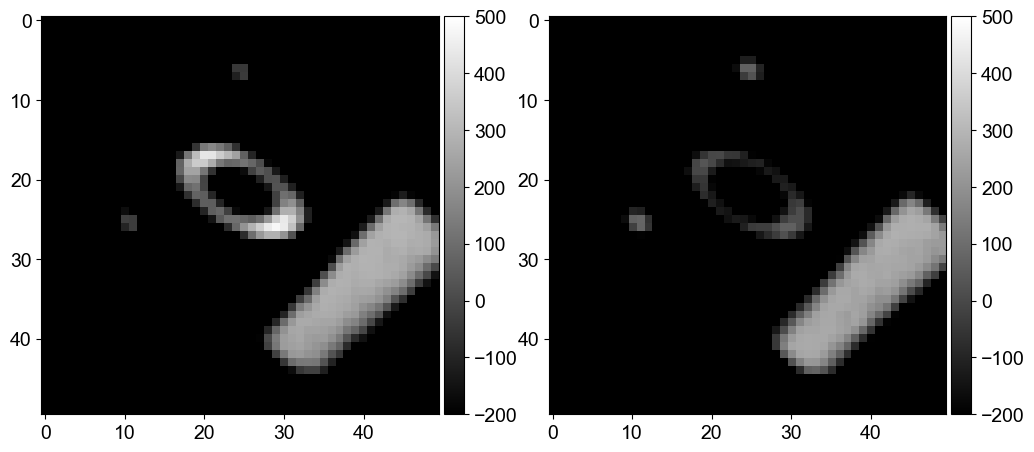

In [50]:
idx = 220

low_ref_sample = low_ref_filtered_maps[idx][20:70, 150:200]
high_ref_sample = high_ref_filtered_maps[idx][20:70, 150:200]

show_pair((low_ref_sample, high_ref_sample), (-200, 500))

In [58]:
from scipy.ndimage import label, find_objects, gaussian_gradient_magnitude

def find_xenon_intensity(image, sigma=1, threshold_factor=1.5):
    edges = gaussian_gradient_magnitude(image, sigma=sigma) # detect edges
    
    # Threshold the edges to create a binary mask for the ring
    threshold = edges.mean() * threshold_factor
    ring_mask = edges > threshold
    
    # Label connected components in the binary mask
    labeled_mask, num_features = label(ring_mask)
    regions = find_objects(labeled_mask)
    
    # Identify the largest region as the center ring
    largest_region = max(regions, key=lambda x: (x[0].stop - x[0].start) * (x[1].stop - x[1].start))
    
    # Create a refined mask for only the center ring
    center_ring_mask = np.zeros_like(ring_mask)
    center_ring_mask[labeled_mask == labeled_mask[largest_region[0].start, largest_region[1].start]] = 1
    
    # Apply the refined mask to the original image
    center_ring_image = np.zeros_like(image)
    center_ring_image[center_ring_mask == 1] = image[center_ring_mask == 1]
    
    # Calculate the average intensity of the center ring pixels
    center_ring_pixels = image[center_ring_mask == 1]
    average_intensity = center_ring_pixels.mean()
    
    return center_ring_pixels, average_intensity

_, xenon_intensity_low = find_xenon_intensity(low_ref_sample)
_, xenon_intensity_high = find_xenon_intensity(high_ref_sample)

print(f'Xenon @ 140KV: {xenon_intensity_high}')
print(f'Xenon @ 80KV: {xenon_intensity_low}')

Xenon @ 140KV: -532.7503276524865
Xenon @ 80KV: -395.27986009090847
